# **Water Management and Forecasting**
### **Project Backgroung**
The arid climate of several Algerian regions and the water-stressed region of Bhopal, effective water management and forecasting are crucial. This project aims to harness the power of machine learning to address the unique water resource challenges faced by both regions. By creating an open-source solution, we aim to empower Algeria and Bhopal to make informed decisions, optimize resource allocation, and build resilient water infrastructure for a sustainable future.
### **Project Goals**
**Develop a Comprehensive Open-Source Water Management and Forecasting System:** Create a user-friendly platform tailored to the specific needs of Algeria and Bhopal, integrating machine learning algorithms for precise water forecasting and efficient water resource management.

- **Enhance Water Resource Utilization:** Improve the sustainable use of water resources in both regions by providing accurate forecasts and real-time monitoring.
- **Capacity Building:** Empower local stakeholders in Algeria and Bhopal with the knowledge and tools necessary to make well-informed decisions about water management.
- **Community Engagement:** Foster collaboration among local government agencies, NGOs, and the research community to collectively address water-related challenges in both regions.

**Data Source:**</BR>
* https://developers.google.com/earth-engine/datasets/catalog/NOAA_GFS0P25
* https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V022_CLSM_G025_DA1D

# **Import Modules**

In [2]:
#### Import the libraries needed
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import os
import glob

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import statsmodels.api as sm

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')
%matplotlib notebook
%matplotlib inline

# **Set Environment**

In [3]:
import plotly.io as pio
pio.renderers.default = "vscode"

In [4]:
# Set up directory
working_directory = Path.cwd()
src = working_directory.parents[1]
# data directory
raw_data_directory = src / 'data' / 'raw'
processed_data_directory = src / 'data' / 'processed'
final_data_directory = src / 'data' / 'final'

In [5]:
# Set pd.options to add slide bars
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [6]:
# Set default title color
plt.style.use('fivethirtyeight')

# set default plt figure size
plt.rcParams["figure.figsize"] = [10, 5]
# suptitle
plt.rcParams["figure.titlesize"] = 22
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams['text.color'] = '#333333'
# title
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams['axes.titlecolor'] = '#333333'
# label
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.labelcolor'] = '#333333'
# spines
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
# tick
plt.rcParams['xtick.color'] = "#333333"
plt.rcParams['ytick.color'] = "#333333"

## **Load all GFS Datasets and Merge into gfs_df**

* **temperature_2m_above_ground (°C)**: Temperature 2m above ground
* **specific_humidity_2m_above_ground (%)**: Specific humidity 2m above ground
* **relative_humidity_2m_above_ground (%)**: Relative humidity 2m above ground
* **u_component_of_wind_10m_above_ground (m/s)**: U component of wind 10m above ground
* **v_component_of_wind_10m_above_ground (m/s)**: V component of wind 10m above ground
* **total_precipitation_surface (kg/m^2)**: Cumulative precipitation at surface for the previous 1-6 hours, depending on the value of the "forecast_hours" property according to the formula ((F - 1) % 6) + 1 (and only for assets with forecast_hours > 0)
* **precipitable_water_entire_atmosphere (kg/m^2)**: Precipitable water for entire atmosphere
* **total_cloud_cover_entire_atmosphere (%)**: Total cloud cover for entire atmosphere (only for assets with forecast_hours > 0)
* **downward_shortwave_radiation_flux (W/m^2)**: Downward shortwave radiation flux (only for assets with forecast_hours > 0)

In [7]:
# save result in list -> all_filenames
bhopal_filenames = [file_name for file_name in glob.glob(str(raw_data_directory) + "/*.csv") if os.path.basename(file_name).startswith('GFS_Bhopal')]

# Combine all files in the list
gfs_df = pd.concat([pd.read_csv(f) for f in bhopal_filenames])

In [8]:
# Convert the 'date' columns to datetime data type
gfs_df['date'] = pd.to_datetime(gfs_df['date'], format='%y-%m-%d')

In [9]:
gfs_df.head()

,date,city,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface
0,2015-04-01,Bhopal,31.381519,0.005640,19.084161,4.671449,-0.277626,19.053919,0.0
1,2015-04-02,Bhopal,31.612318,0.006702,22.664057,5.663895,-0.951907,19.920647,0.0
2,2015-04-03,Bhopal,30.854070,0.006804,23.969701,5.704286,-0.857162,19.664423,0.0
3,2015-04-04,Bhopal,30.046127,0.008165,30.080859,2.575579,-1.547093,24.770628,0.0
4,2015-04-05,Bhopal,30.523074,0.007366,26.557658,-0.549178,-0.442961,23.765168,0.0


In [10]:
gfs_df.tail()

,date,city,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface
343,2023-12-10,Bhopal,18.811834,0.006121,43.662294,-1.405728,-0.565707,12.593095,0.000389
344,2023-12-11,Bhopal,18.872122,0.006296,44.810857,-1.503734,-0.283899,14.011080,0.028797
345,2023-12-12,Bhopal,18.785527,0.005872,42.018555,-1.647457,-0.419264,13.332485,0.010552
346,2023-12-13,Bhopal,18.444809,0.005759,42.108677,-1.865238,-0.799219,14.464455,0.015756
347,2023-12-14,Bhopal,18.650056,0.005858,42.060450,-1.756230,-0.815621,13.921977,0.000171


## **Load all GLDAS Datasets**

* **ACond_tavg (m/s)**: 	Aerodynamic conductance
* **AvgSurfT_tavg (K)**: 	Average surface skin temperature
* **CanopInt_tavg (kg/m^2)**: 	Plant canopy surface water
* **ECanop_tavg (kg/m^2/s)**: 	Canopy water evaporation
* **ESoil_tavg (kg/m^2/s)**: 	Direct evaporation from bare soil
* **Evap_tavg (kg/m^2/s)**: 	Evapotranspiration                 
* **GWS_tavg (mm)**: 	Ground water storage
* **Lwnet_tavg (W/m^2)**: 	Net long-wave radiation flux
* **Qg_tavg (W/m^2)**: 	Heat flux
* **Qh_tavg (W/m^2)**: 	Sensible heat net flux
* **Qle_tavg (W/m^2)**: 	Latent heat net flux
* **Qs_tavg (W/m^2/s)**: 	Storm surface runoff                 
* **SnowT_tavg (K)**: 	Snow Surface temperature
* **SoilMoist_P_tavg (kg/m^2)**: 	Profile Soil moisture
* **SoilMoist_RZ_tavg (kg/m^2)**: 	Root Zone Soil moisture
* **SoilMoist_S_tavg (kg/m^2)**: 	Surface Soil moisture
* **Swnet_tavg (W/m^2)**: 	Net short wave radiation flux
* **TVeg_tavg (kg/m^2/s)**: 	Transpiration               
* **TWS_tavg (mm)**: 	Terrestrial water storage

In [11]:
# Convert the 'date' columns to datetime data type
file = os.path.join(raw_data_directory, 'GLDAS_Bhopal_2010_2023.csv')
gldas_df = pd.read_csv(file)
gldas_df['date'] = pd.to_datetime(gldas_df['date'], format='%y-%m-%d')

In [12]:
# Drop the columns that have all 0 values
gldas_df.drop(['SWE_tavg', 'SnowDepth_tavg', 'Qsb_tavg', 'Qsm_tavg', 'EvapSnow_tavg'], axis=1, inplace=True)

In [13]:
gldas_df.head()

,date,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
0,2010-01-01,Bhopal,0.010088,287.688380,0.001156,2.932935e-08,0.000012,0.000015,883.827648,-90.931169,-13.290055,37.562870,35.926709,0.000000e+00,287.688380,1172.228199,288.400510,5.566383,151.129770,0.000002,1172.229304
1,2010-01-02,Bhopal,0.010061,289.268913,0.000401,2.920452e-09,0.000012,0.000015,883.432609,-68.572377,-1.099613,42.294629,36.103128,0.000000e+00,289.268913,1171.363238,287.930671,5.547952,145.878682,0.000002,1171.363680
2,2010-01-03,Bhopal,0.010747,292.449339,0.000948,7.901975e-09,0.000014,0.000017,883.026668,-53.388871,8.170513,37.794927,42.585784,3.507778e-10,292.449339,1170.347264,287.320660,5.488808,141.945173,0.000003,1170.348275
3,2010-01-04,Bhopal,0.011983,289.668102,0.000724,1.918644e-08,0.000011,0.000013,882.605022,-76.923632,-13.948946,49.884944,33.185483,0.000000e+00,289.668102,1169.410008,286.805072,5.509292,146.034988,0.000002,1169.410822
4,2010-01-05,Bhopal,0.010241,287.474046,0.000275,1.576623e-09,0.000011,0.000013,882.173136,-91.107395,-16.264285,45.596330,32.737269,0.000000e+00,287.474046,1168.653461,286.480318,5.510678,153.171961,0.000002,1168.653736


In [14]:
gldas_df.tail()

,date,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
4924,2023-06-26,Bhopal,0.014880,301.319386,0.010942,0.000002,0.000024,0.000028,821.132273,-3.098705,-10.344487,42.815345,68.294639,0.000004,301.319386,1119.148058,298.015849,6.533273,103.863962,0.000002,1119.159069
4925,2023-06-27,Bhopal,0.016214,301.113478,0.010765,0.000002,0.000026,0.000030,822.014210,0.347042,-7.623907,34.966429,74.206189,0.000018,301.113478,1123.364814,301.350545,6.898181,101.200953,0.000002,1123.375532
4926,2023-06-28,Bhopal,0.016272,300.568071,0.012465,0.000002,0.000031,0.000037,823.678898,4.282264,-8.339805,31.559352,90.448594,0.000053,300.568071,1134.990114,311.311238,7.512892,109.385402,0.000003,1135.002598
4927,2023-06-29,Bhopal,0.017152,300.438963,0.012693,0.000002,0.000028,0.000034,826.473011,4.832132,-6.900661,38.382987,84.663859,0.000030,300.438963,1144.042161,317.569183,7.319170,111.313468,0.000004,1144.054883
4928,2023-06-30,Bhopal,0.016794,300.249694,0.013172,0.000002,0.000025,0.000032,829.937107,1.440541,-5.905571,30.057209,79.849653,0.000008,300.249694,1151.335034,321.397936,7.022767,102.562258,0.000005,1151.348196


## **Load Bhopal-population-2023-11-22.csv**

* **date**
* **Population**
* **Annual Change**

In [15]:
# Convert the 'date' columns to datetime data type
file = os.path.join(processed_data_directory, 'Population data/Bhopal-population-2023-11-22.csv')
population_df = pd.read_csv(file)
population_df['date'] = pd.to_datetime(population_df['date'], format='%Y-%m-%d')
population_df.head()

,date,Population,Annual Change
0,1950-12-31,100000,NaN
1,1951-12-31,105000,5.00
2,1952-12-31,114000,8.57
3,1953-12-31,123000,7.89
4,1954-12-31,133000,8.13


In [16]:
population_df.tail()

,date,Population,Annual Change
81,2031-12-31,3075000,2.23
82,2032-12-31,3142000,2.18
83,2033-12-31,3211000,2.20
84,2034-12-31,3279000,2.12
85,2035-12-31,3348000,2.10


## **Descriptive Statistics and Basic Information**

In [17]:
gfs_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,3147,2019-08-07 18:29:10.238322432,2015-04-01 00:00:00,2017-06-06 12:00:00,2019-08-04 00:00:00,2021-09-30 12:00:00,2023-12-14 00:00:00,NaN
temperature_2m_above_ground,3147.0,1120432525001593.5,14.31998,22.685267,26.001753,30.714626,3526001156179930624.0,62854167551381376.0
specific_humidity_2m_above_ground,3147.0,0.012754,0.002064,0.005188,0.007549,0.016433,8.668938,0.154454
relative_humidity_2m_above_ground,3147.0,45.439327,6.948661,24.856172,39.345853,68.742206,91.5314,24.754418
u_component_of_wind_10m_above_ground,3147.0,1.591564,-5.569351,-0.661148,1.344172,3.711401,242.03414,4.930974
v_component_of_wind_10m_above_ground,3147.0,-0.709106,-4.556643,-1.405165,-0.806897,-0.071909,16.735682,1.077224
precipitable_water_entire_atmosphere,3147.0,30.342142,4.866504,15.021756,22.526799,49.913735,66.880519,18.360017
total_precipitation_surface,3147.0,0.572979,-0.970291,0.000981,0.035105,0.806079,7.303167,0.977914


In [18]:
gldas_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,4929,2016-09-30 00:00:00,2010-01-01 00:00:00,2013-05-17 00:00:00,2016-09-30 00:00:00,2020-02-14 00:00:00,2023-06-30 00:00:00,NaN
ACond_tavg,4929.0,0.012279,0.005659,0.009152,0.011273,0.014634,0.034719,0.004126
AvgSurfT_tavg,4929.0,299.473782,283.791125,294.264446,298.851911,303.734282,316.891798,7.009811
CanopInt_tavg,4929.0,0.009041,0.000001,0.000072,0.0006,0.010698,0.082886,0.015923
ECanop_tavg,4929.0,0.000001,-0.0,0.0,0.0,0.000001,0.000008,0.000002
ESoil_tavg,4929.0,0.000016,0.000001,0.000011,0.000016,0.000021,0.000044,0.000007
Evap_tavg,4929.0,0.000026,0.000001,0.000013,0.000023,0.000037,0.000077,0.000015
GWS_tavg,4929.0,925.192461,772.309685,841.604381,904.001347,986.725043,1224.835834,103.145223
Lwnet_tavg,4929.0,-55.191196,-131.540335,-82.634341,-62.769718,-24.03882,20.232714,35.917618
Qg_tavg,4929.0,0.02892,-30.42168,-4.308194,-0.266609,5.043147,19.777545,7.012558


In [19]:
population_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,86,1993-07-01 05:51:37.674418560,1950-12-31 00:00:00,1972-03-31 12:00:00,1993-07-01 12:00:00,2014-09-30 18:00:00,2035-12-31 00:00:00,NaN
Population,86.0,1299697.674419,100000.0,395750.0,1126500.0,2042000.0,3348000.0,976193.725588
Annual Change,85.0,4.234353,2.1,2.58,3.26,5.63,8.57,1.916129


In [20]:
# Check the shape of the datasets
print("Shape of datasets")
print("GFS: ", gfs_df.shape)
print("GLADAS: ", gldas_df.shape)
print("Population: ", population_df.shape)

Shape of datasets
GFS:  (3147, 9)
GLADAS:  (4929, 21)
Population:  (86, 3)


In [21]:
# Check the null values
print("Number of null values")
print("GFS: ", gfs_df.isna().sum().sum())
print("GLADAS: ", gldas_df.isna().sum().sum())
print("Population: ", population_df.isna().sum().sum())

Number of null values
GFS:  0
GLADAS:  0
Population:  1


In [22]:
# Print date range
print("GFS: ", gfs_df['date'].min(), gfs_df['date'].max())
print("GLADS: ", gldas_df['date'].min(), gldas_df['date'].max())
print("Population: ", population_df['date'].min(), population_df['date'].max())

GFS:  2015-04-01 00:00:00 2023-12-14 00:00:00
GLADS:  2010-01-01 00:00:00 2023-06-30 00:00:00
Population:  1950-12-31 00:00:00 2035-12-31 00:00:00


In [23]:
# Check columns
gfs_num_cols = gfs_df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {gfs_num_cols}")
print()

gfs_cat_cols = gfs_df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {gfs_cat_cols}")

Numerical Columns: Index(['temperature_2m_above_ground', 'specific_humidity_2m_above_ground',
       'relative_humidity_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'precipitable_water_entire_atmosphere', 'total_precipitation_surface'],
      dtype='object')

Categorical Columns: Index(['date', 'city'], dtype='object')


In [24]:
# Check columns
gldas_num_cols = gldas_df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {gldas_num_cols}")
print()
gldas_cat_cols = gldas_df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {gldas_cat_cols}")

Numerical Columns: Index(['ACond_tavg', 'AvgSurfT_tavg', 'CanopInt_tavg', 'ECanop_tavg',
       'ESoil_tavg', 'Evap_tavg', 'GWS_tavg', 'Lwnet_tavg', 'Qg_tavg',
       'Qh_tavg', 'Qle_tavg', 'Qs_tavg', 'SnowT_tavg', 'SoilMoist_P_tavg',
       'SoilMoist_RZ_tavg', 'SoilMoist_S_tavg', 'Swnet_tavg', 'TVeg_tavg',
       'TWS_tavg'],
      dtype='object')

Categorical Columns: Index(['date', 'city'], dtype='object')


In [25]:
# Check columns
population_num_cols = population_df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {population_num_cols}")
print()
population_cat_cols = population_df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {population_cat_cols}")

Numerical Columns: Index([' Population', ' Annual Change'], dtype='object')

Categorical Columns: Index(['date'], dtype='object')


## **Merge GLDAS and GFS Datasets**
* GFS_Bhopal_xxxx.csv where xxxx are from 2014 to 2023
* GLDAS_Bhopal_2010_2023.csv

In [26]:
# Merge gldas_df and gfs_df
gldas_df.drop('city', axis=1, inplace=True)
gfs_df.drop('city', axis=1, inplace=True)
df = pd.merge(gfs_df, gldas_df, on='date', how='inner')
df.head(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
0,2015-04-01,31.381519,0.005640,19.084161,4.671449,-0.277626,19.053919,0.0,0.009535,301.828791,0.000085,6.492022e-10,0.000028,0.000029,878.020093,-90.396704,5.002746,57.287802,70.673777,0.0,301.828791,1153.966420,275.946408,4.782809,223.362352,6.349899e-07,1153.966582
1,2015-04-02,31.612318,0.006702,22.664057,5.663895,-0.951907,19.920647,0.0,0.011490,302.765242,0.000052,2.799420e-10,0.000028,0.000028,877.131936,-81.731904,9.743703,60.882683,69.560302,0.0,302.765242,1151.749923,274.617967,4.659694,221.923497,4.469356e-07,1151.749969
2,2015-04-03,30.854070,0.006804,23.969701,5.704286,-0.857162,19.664423,0.0,0.012793,303.068777,0.000037,1.457972e-10,0.000026,0.000027,876.220241,-80.587193,6.332965,65.454717,65.798244,0.0,303.068777,1149.649158,273.428841,4.484641,218.171090,3.210499e-07,1149.649124


In [27]:
df.tail(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
2977,2023-06-28,26.892660,0.017768,76.791421,4.170625,1.146734,60.177433,1.603568,0.016272,300.568071,0.012465,0.000002,0.000031,0.000037,823.678898,4.282264,-8.339805,31.559352,90.448594,0.000053,300.568071,1134.990114,311.311238,7.512892,109.385402,0.000003,1135.002598
2978,2023-06-29,27.319106,0.018360,77.157611,3.962298,0.360457,62.622001,1.988386,0.017152,300.438963,0.012693,0.000002,0.000028,0.000034,826.473011,4.832132,-6.900661,38.382987,84.663859,0.000030,300.438963,1144.042161,317.569183,7.319170,111.313468,0.000004,1144.054883
2979,2023-06-30,27.389405,0.018356,76.932610,3.849981,-0.129736,62.947182,2.391717,0.016794,300.249694,0.013172,0.000002,0.000025,0.000032,829.937107,1.440541,-5.905571,30.057209,79.849653,0.000008,300.249694,1151.335034,321.397936,7.022767,102.562258,0.000005,1151.348196


## **Add population column**
* Add population from Bhopal-population-2023-11-22.csv

In [28]:
# Add the 'population' column to df
population_df['year'] = population_df['date'].dt.year
df['year'] = df['date'].dt.year
df['population'] = [population_df[population_df['year'] == y][' Population'].values[0] for y in df['year']]

In [29]:
df.head(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,year,population
0,2015-04-01,31.381519,0.005640,19.084161,4.671449,-0.277626,19.053919,0.0,0.009535,301.828791,0.000085,6.492022e-10,0.000028,0.000029,878.020093,-90.396704,5.002746,57.287802,70.673777,0.0,301.828791,1153.966420,275.946408,4.782809,223.362352,6.349899e-07,1153.966582,2015,2108000
1,2015-04-02,31.612318,0.006702,22.664057,5.663895,-0.951907,19.920647,0.0,0.011490,302.765242,0.000052,2.799420e-10,0.000028,0.000028,877.131936,-81.731904,9.743703,60.882683,69.560302,0.0,302.765242,1151.749923,274.617967,4.659694,221.923497,4.469356e-07,1151.749969,2015,2108000
2,2015-04-03,30.854070,0.006804,23.969701,5.704286,-0.857162,19.664423,0.0,0.012793,303.068777,0.000037,1.457972e-10,0.000026,0.000027,876.220241,-80.587193,6.332965,65.454717,65.798244,0.0,303.068777,1149.649158,273.428841,4.484641,218.171090,3.210499e-07,1149.649124,2015,2108000


# **Descriptive Statistics**

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2980 entries, 0 to 2979
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  2980 non-null   datetime64[ns]
 1   temperature_2m_above_ground           2980 non-null   float64       
 2   specific_humidity_2m_above_ground     2980 non-null   float64       
 3   relative_humidity_2m_above_ground     2980 non-null   float64       
 4   u_component_of_wind_10m_above_ground  2980 non-null   float64       
 5   v_component_of_wind_10m_above_ground  2980 non-null   float64       
 6   precipitable_water_entire_atmosphere  2980 non-null   float64       
 7   total_precipitation_surface           2980 non-null   float64       
 8   ACond_tavg                            2980 non-null   float64       
 9   AvgSurfT_tavg                         2980 non-null   float64       
 10  

In [31]:
df.describe(include='all').T

,count,mean,min,25%,50%,75%,max,std
date,2980,2019-05-15 08:39:27.785234944,2015-04-01 00:00:00,2017-04-25 18:00:00,2019-05-12 12:00:00,2021-05-28 06:00:00,2023-06-30 00:00:00,NaN
temperature_2m_above_ground,2980.0,1183221864489936.0,14.31998,22.656726,26.153193,31.18399,3526001156179930624.0,64591343554758112.0
specific_humidity_2m_above_ground,2980.0,0.012732,0.002064,0.005105,0.007321,0.016144,8.668938,0.15872
relative_humidity_2m_above_ground,2980.0,44.397227,6.948661,23.97865,38.300223,65.515923,91.5314,24.596225
u_component_of_wind_10m_above_ground,2980.0,1.603169,-5.569351,-0.65882,1.3426,3.725964,242.03414,5.038575
v_component_of_wind_10m_above_ground,2980.0,-0.725194,-4.556643,-1.41731,-0.829299,-0.0804,16.735682,1.090489
precipitable_water_entire_atmosphere,2980.0,29.876516,4.866504,14.838999,22.242183,49.188495,66.880519,18.225487
total_precipitation_surface,2980.0,0.557108,-0.970291,0.00088,0.033587,0.760938,7.303167,0.968092
ACond_tavg,2980.0,0.012096,0.006004,0.009135,0.011237,0.014272,0.034719,0.003918
AvgSurfT_tavg,2980.0,299.75858,283.791125,294.519543,299.169344,304.15274,316.891798,6.927656


In [32]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
print(f"First date: {df['date'].min()}")
print(f"Last date: {df['date'].max()}")

First date: 2015-04-01 00:00:00
Last date: 2023-06-30 00:00:00


## **Feature Engineering**
* The water surface in Bhopal is mainly provided by two artificial lakes: the Upper Lake and the Lower Lake. The Upper Lake has a surface area of **36 km2** and a catchment area of 361 km2. The Lower Lake has a surface area of **1.29 km2** and a catchment area of 9.6 km2.
* A new feature, surplus has been added
* 'surplus' was calculated based on the Bhopal daily water demand per person: 135 (l/c/d)
$$Daily Water Volume (km^{3})  = (36 + 1.29) * TWS * 10^{-6} / 365$$
$$Daily Water Volume (Liter)  = Daily Water Volume (km^{3}) * 10^{12}$$
$$Daily Water Demand in Bhopal (Liters) = 135 * Population$$
$$Daily Water Surplus/Deficit in Bhopal (Liters) = Daily Water Demand in Bhopal (Liters) - Daily Water Volume (Liter)$$

###### **Reference**: Lake Bhopal Conservation and Management Project</br>
###### **URL**: https://www.jica.go.jp/Resource/english/our_work/evaluation/oda_loan/post/2007/pdf/project32_full.pdf</br>
###### * **Reference**: 2.1 Performance Audit on Water Supply Management in Bhopal and Indore Municipal Corporations</br>
###### * **URL**: https://cag.gov.in/uploads/download_audit_report/2019/(10)%20Chapter-II%20PA%20on%20WSM-05f96ba7abda563.27223354.pdf</br>

In [33]:
lower_lake_area = 36
upper_lake_area = 1.29
# Domestic use
daily_min_water_demand_per_capita = 135
# 225 max add 'max water demand'
daily_max_water_demand_per_capita = 225
# Calculate daily water volume in liter
daily_water_volume = (lower_lake_area + upper_lake_area) * (df['TWS_tavg'] * 10**(-6) / 365) * 10**(12)
daily_min_water_demand = daily_min_water_demand_per_capita * df['population']
df['min_water_availability'] = daily_water_volume - daily_min_water_demand
daily_max_water_demand = daily_max_water_demand_per_capita * df['population']
df['max_water_availability'] = daily_water_volume - daily_max_water_demand

In [34]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,2980,2019-05-15 08:39:27.785234944,2015-04-01 00:00:00,2017-04-25 18:00:00,2019-05-12 12:00:00,2021-05-28 06:00:00,2023-06-30 00:00:00,NaN
temperature_2m_above_ground,2980.0,1183221864489936.0,14.31998,22.656726,26.153193,31.18399,3526001156179930624.0,64591343554758112.0
specific_humidity_2m_above_ground,2980.0,0.012732,0.002064,0.005105,0.007321,0.016144,8.668938,0.15872
relative_humidity_2m_above_ground,2980.0,44.397227,6.948661,23.97865,38.300223,65.515923,91.5314,24.596225
u_component_of_wind_10m_above_ground,2980.0,1.603169,-5.569351,-0.65882,1.3426,3.725964,242.03414,5.038575
v_component_of_wind_10m_above_ground,2980.0,-0.725194,-4.556643,-1.41731,-0.829299,-0.0804,16.735682,1.090489
precipitable_water_entire_atmosphere,2980.0,29.876516,4.866504,14.838999,22.242183,49.188495,66.880519,18.225487
total_precipitation_surface,2980.0,0.557108,-0.970291,0.00088,0.033587,0.760938,7.303167,0.968092
ACond_tavg,2980.0,0.012096,0.006004,0.009135,0.011237,0.014272,0.034719,0.003918
AvgSurfT_tavg,2980.0,299.75858,283.791125,294.519543,299.169344,304.15274,316.891798,6.927656


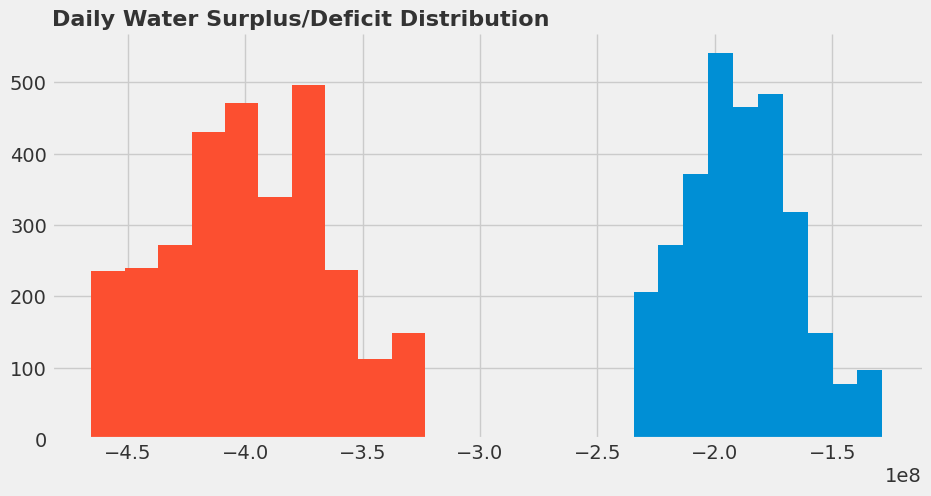

In [36]:
plt.title('Daily Water Surplus/Deficit Distribution')
df['min_water_availability'].hist()
df['max_water_availability'].hist();

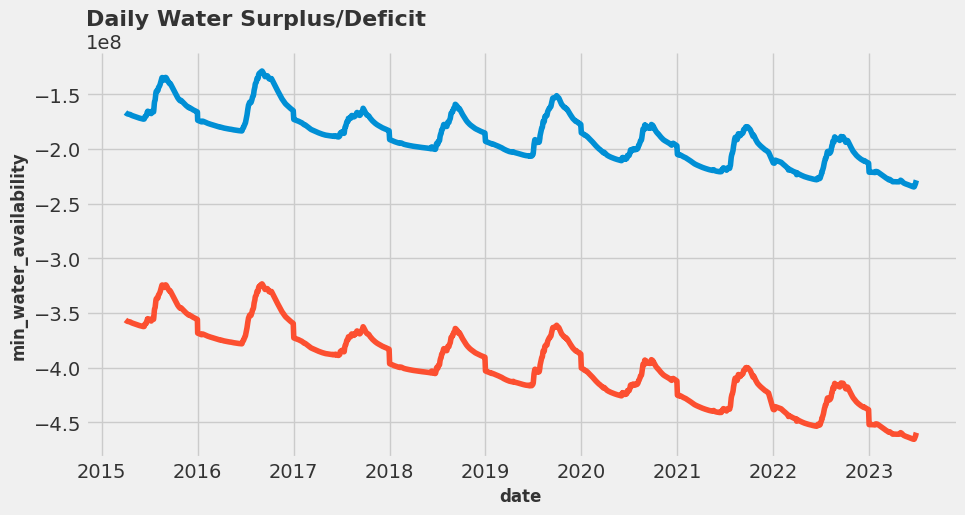

In [37]:
plt.title('Daily Water Surplus/Deficit')
sns.lineplot(x=df['date'], y=df['min_water_availability'])
sns.lineplot(x=df['date'], y=df['max_water_availability']);

In [38]:
# Save the dataframe
file = os.path.join(final_data_directory, "GLDAS_GFS_population_Bhopal_2015_2023_final.csv")
df.to_csv(file, index=False, encoding='utf-8-sig')

## **Verify the Merged File**

In [39]:
df = pd.read_csv(file)
df.head(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,year,population,min_water_availability,max_water_availability
0,2015-04-01,31.381519,0.005640,19.084161,4.671449,-0.277626,19.053919,0.0,0.009535,301.828791,0.000085,6.492022e-10,0.000028,0.000029,878.020093,-90.396704,5.002746,57.287802,70.673777,0.0,301.828791,1153.966420,275.946408,4.782809,223.362352,6.349899e-07,1153.966582,2015,2108000,-1.666857e+08,-3.564057e+08
1,2015-04-02,31.612318,0.006702,22.664057,5.663895,-0.951907,19.920647,0.0,0.011490,302.765242,0.000052,2.799420e-10,0.000028,0.000028,877.131936,-81.731904,9.743703,60.882683,69.560302,0.0,302.765242,1151.749923,274.617967,4.659694,221.923497,4.469356e-07,1151.749969,2015,2108000,-1.669122e+08,-3.566322e+08
2,2015-04-03,30.854070,0.006804,23.969701,5.704286,-0.857162,19.664423,0.0,0.012793,303.068777,0.000037,1.457972e-10,0.000026,0.000027,876.220241,-80.587193,6.332965,65.454717,65.798244,0.0,303.068777,1149.649158,273.428841,4.484641,218.171090,3.210499e-07,1149.649124,2015,2108000,-1.671268e+08,-3.568468e+08


In [40]:
df.tail(3)

,date,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qs_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,year,population,min_water_availability,max_water_availability
2977,2023-06-28,26.892660,0.017768,76.791421,4.170625,1.146734,60.177433,1.603568,0.016272,300.568071,0.012465,0.000002,0.000031,0.000037,823.678898,4.282264,-8.339805,31.559352,90.448594,0.000053,300.568071,1134.990114,311.311238,7.512892,109.385402,0.000003,1135.002598,2023,2565000,-2.303182e+08,-4.611682e+08
2978,2023-06-29,27.319106,0.018360,77.157611,3.962298,0.360457,62.622001,1.988386,0.017152,300.438963,0.012693,0.000002,0.000028,0.000034,826.473011,4.832132,-6.900661,38.382987,84.663859,0.000030,300.438963,1144.042161,317.569183,7.319170,111.313468,0.000004,1144.054883,2023,2565000,-2.293933e+08,-4.602433e+08
2979,2023-06-30,27.389405,0.018356,76.932610,3.849981,-0.129736,62.947182,2.391717,0.016794,300.249694,0.013172,0.000002,0.000025,0.000032,829.937107,1.440541,-5.905571,30.057209,79.849653,0.000008,300.249694,1151.335034,321.397936,7.022767,102.562258,0.000005,1151.348196,2023,2565000,-2.286482e+08,-4.594982e+08
